# Deep Vision
___

**Author** : Aman Hussain  
**Email** : aman@amandavinci.me  
**Description** : Classifying images of dogs and cats by finetuning the VGG16 model

## Import Libraries

#### Scientific Computing Stack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Custom Packages

In [2]:
import os, json

from helper import utils
from helper.utils import plots

from helper import vgg16
from helper.vgg16 import Vgg16

Using cuDNN version 5103 on context None
Mapped name None to device cuda0: Tesla K80 (0000:00:04.0)
Using Theano backend.


## Declaring paths & global parameters

The path to the dataset is defined here. It will point to the sample folder which contains lesser number of images for quick and iterative training on the local machine. For the final training, on the cloud we must change the path to the one commented out below.

In [3]:
# path = '../data/dogscats/sample/'
path = '../data/dogscats/'

The default batchsize for training and validation purposes

In [4]:
batchsize = 64

## Data Exploration

Instantiating the VGG16 class which implements the required utility methods

In [5]:
vgg = Vgg16()

Getting the training and validation batches

In [7]:
batches = vgg.get_batches(path+'train', batch_size=batchsize)
val_batches = vgg.get_batches(path+'valid', batch_size=batchsize)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Visualizing the images, only if we are exploring the samples

In [8]:
if path == '../data/dogscats/sample/':
    imgs, labels = next(batches)
    val_imgs, val_labels = next(val_batches)
    labels = ['dog' if i[0]==0 else 'cat' for i in labels]
    val_labels = ['dog' if i[0]==0 else 'cat' for i in val_labels]
    plots(val_imgs, figsize=(20,10), titles=val_labels)

## Finetuning

In [9]:
vgg.finetune(batches)

In [10]:
%%time
vgg.fit(batches, val_batches, nb_epoch=3)

Epoch 1/3
20000/20000 [==============================] - 492s - loss: 0.1259 - acc: 0.9662 - val_loss: 0.0592 - val_acc: 0.9836
Epoch 2/3
20000/20000 [==============================] - 488s - loss: 0.0985 - acc: 0.9761 - val_loss: 0.0606 - val_acc: 0.9836
Epoch 3/3
20000/20000 [==============================] - 489s - loss: 0.0937 - acc: 0.9781 - val_loss: 0.0684 - val_acc: 0.9850
CPU times: user 31min 53s, sys: 5min 23s, total: 37min 16s
Wall time: 25min 35s


## Model Testing

Due to the quirkiness of the ImageDataGenerator.flow_from_directory() used by vgg.get_batches(), we have to make a sub directory under test directory by the name 'subdir_for_keras_ImageDataGenerator'.

In [11]:
batch_size = len(os.listdir(path+'test'+'/subdir_for_keras_ImageDataGenerator'))

With the class_mode set to None, it will return only the batch of images without labels

In [12]:
testbatch = vgg.get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)

Found 12500 images belonging to 1 classes.


In [13]:
test_imgs = next(testbatch) 

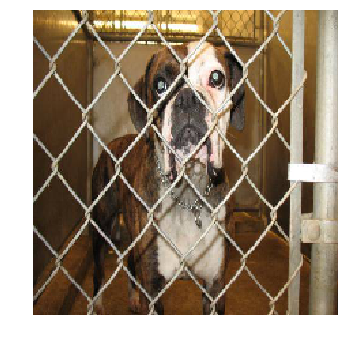

In [29]:
plots(test_imgs[1000:1001])

In [30]:
probab, prediction, prediction_labels = vgg.predict(test_imgs[1000:1001], details = True)

In [32]:
prediction_labels

['dogs']

Here,we visualize the test images

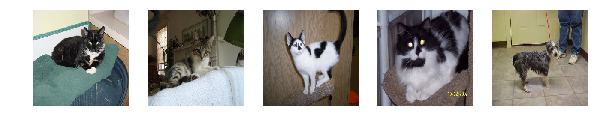

In [33]:
plots(test_imgs[:5])

In [36]:
probab, prediction, prediction_labels = vgg.predict(test_imgs[:5], details = True)
print(prediction_labels, probab, prediction)

['cats', 'cats', 'cats', 'cats', 'dogs'] [ 1.  1.  1.  1.  1.] [0 0 0 0 1]


Here, we make the predictions using our trained model

In [37]:
%%time
probab, prediction, prediction_labels = vgg.predict(test_imgs, details = True)

CPU times: user 3min 14s, sys: 50.9 s, total: 4min 5s
Wall time: 4min 5s


## Results

Preparing to save the predictions as submissions to the Kaggle competetion

In [38]:
np.save(path+'submissions/probab', probab)
np.save(path+'submissions/prediction', prediction)
np.save(path+'submissions/prediction_labels', prediction_labels)

Save the trained model

In [40]:
vgg.model.save("../models/vgg_dogsVScats.h5")

In [41]:
for predicted, index in enumerate(prediction):
    # When a cat is predicted, get the complimentary value
    if predicted == 0:
        probab[index] = 1 - probab[index]

In [42]:
index = [str(i) for i in range(1, batch_size+1)]
index.insert(0, 'id')

labels_pred = [str(label) for label in prediction]
labels_pred.insert(0, 'label')

labels_prob = [str(label) for label in probab]
labels_prob.insert(0, 'label')

In [43]:
submission_array_pred = np.vstack((index, labels_pred)).T.astype('str')
submission_array_prob = np.vstack((index, labels_prob)).T.astype('str')

Saving the array as a CSV

In [44]:
np.savetxt(path+'submissions/submission_pred.csv', submission_array_pred, delimiter=",", fmt='%1s')
np.savetxt(path+'submissions/submission_prob.csv', submission_array_prob, delimiter=",", fmt='%1s')

___

## Correcting Submissions after Training

In [23]:
batch_size = len(os.listdir(path+'test'+'/subdir_for_keras_ImageDataGenerator'))

In [13]:
probab = np.load(path+'submissions/probab.npy')
prediction = np.load(path+'submissions/prediction.npy')
prediction_labels = np.load(path+'submissions/prediction_labels.npy')

In [14]:
probab[:5]

array([ 1.        ,  0.98002827,  1.        ,  1.        ,  1.        ], dtype=float32)

In [15]:
prediction[:5]

array([0, 0, 0, 0, 1])

In [16]:
prediction_labels[:5]

array([b'cats', b'cats', b'cats', b'cats', b'dogs'],
      dtype='|S4')

In [17]:
for predicted, index in enumerate(prediction):
    # When a cat is predicted, get the complimentary value
    if predicted == 0:
        probab[index] = 1 - probab[index]

In [18]:
probab[:10]

array([ 0.        ,  0.98002827,  1.        ,  1.        ,  1.        ,
        0.99999928,  1.        ,  0.98711455,  1.        ,  1.        ], dtype=float32)

In [19]:
prediction[:10]

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [24]:
index = [str(i) for i in range(1, batch_size+1)]
index.insert(0, 'id')

labels_pred = [str(label) for label in prediction]
labels_pred.insert(0, 'label')

labels_prob = [str(label) for label in probab]
labels_prob.insert(0, 'label')

In [25]:
submission_array_pred = np.vstack((index, labels_pred)).T.astype('str')
submission_array_prob = np.vstack((index, labels_prob)).T.astype('str')

In [26]:
np.savetxt(path+'submissions/submission_pred.csv', submission_array_pred, delimiter=",", fmt='%1s')
np.savetxt(path+'submissions/submission_prob.csv', submission_array_prob, delimiter=",", fmt='%1s')